Some random analysis inspired by https://www.bogleheads.org/forum/viewtopic.php?t=272007

Data obtained from https://www.alphavantage.co

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
from matplotlib import pyplot as plt

from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
vtsmx = pd.read_csv("VTSMX.csv")

In [3]:
vustx = pd.read_csv("VUSTX.csv")

In [4]:
vix = pd.read_csv("VIX.csv")

In [5]:
vtsmx

,timestamp,open,high,low,close,volume
0,2020-02-11,82.89,82.89,82.89,82.89,0
1,2020-02-10,82.69,82.69,82.69,82.69,0
2,2020-02-07,82.08,82.08,82.08,82.08,0
3,2020-02-06,82.54,82.54,82.54,82.54,0
4,2020-02-05,82.31,82.31,82.31,82.31,0
...,...,...,...,...,...,...
5049,2000-01-14,33.18,33.18,33.18,33.18,0
5050,2000-01-13,32.79,32.79,32.79,32.79,0
5051,2000-01-12,32.29,32.29,32.29,32.29,0
5052,2000-01-11,32.51,32.51,32.51,32.51,0


In [6]:
vustx

,timestamp,open,high,low,close,volume
0,2020-02-11,13.90,13.90,13.90,13.90,0
1,2020-02-10,13.97,13.97,13.97,13.97,0
2,2020-02-07,13.93,13.93,13.93,13.93,0
3,2020-02-06,13.78,13.78,13.78,13.78,0
4,2020-02-05,13.71,13.71,13.71,13.71,0
...,...,...,...,...,...,...
5049,2000-01-14,9.58,9.58,9.58,9.58,0
5050,2000-01-13,9.62,9.62,9.62,9.62,0
5051,2000-01-12,9.53,9.53,9.53,9.53,0
5052,2000-01-11,9.55,9.55,9.55,9.55,0


In [7]:
df = pd.DataFrame()

In [8]:
df["timestamp"] = vustx["timestamp"]

In [9]:
df["vustx_close"] = vustx["close"]

In [10]:
df["vix_close"] = vix["close"]

In [11]:
df["vtsmx_close"] = vtsmx["close"]

In [12]:
df = df.reindex(index=df.index[::-1])
df.reset_index(inplace=True, drop=True)

In [13]:
df["timestamp"] = df["timestamp"].apply(lambda x: np.datetime64(x))

In [14]:
# cut to time range we care about

df = df[(df["timestamp"] > np.datetime64("2005-01-01"))&(df["timestamp"] < np.datetime64("2020-12-31"))]

/home/rmeng/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


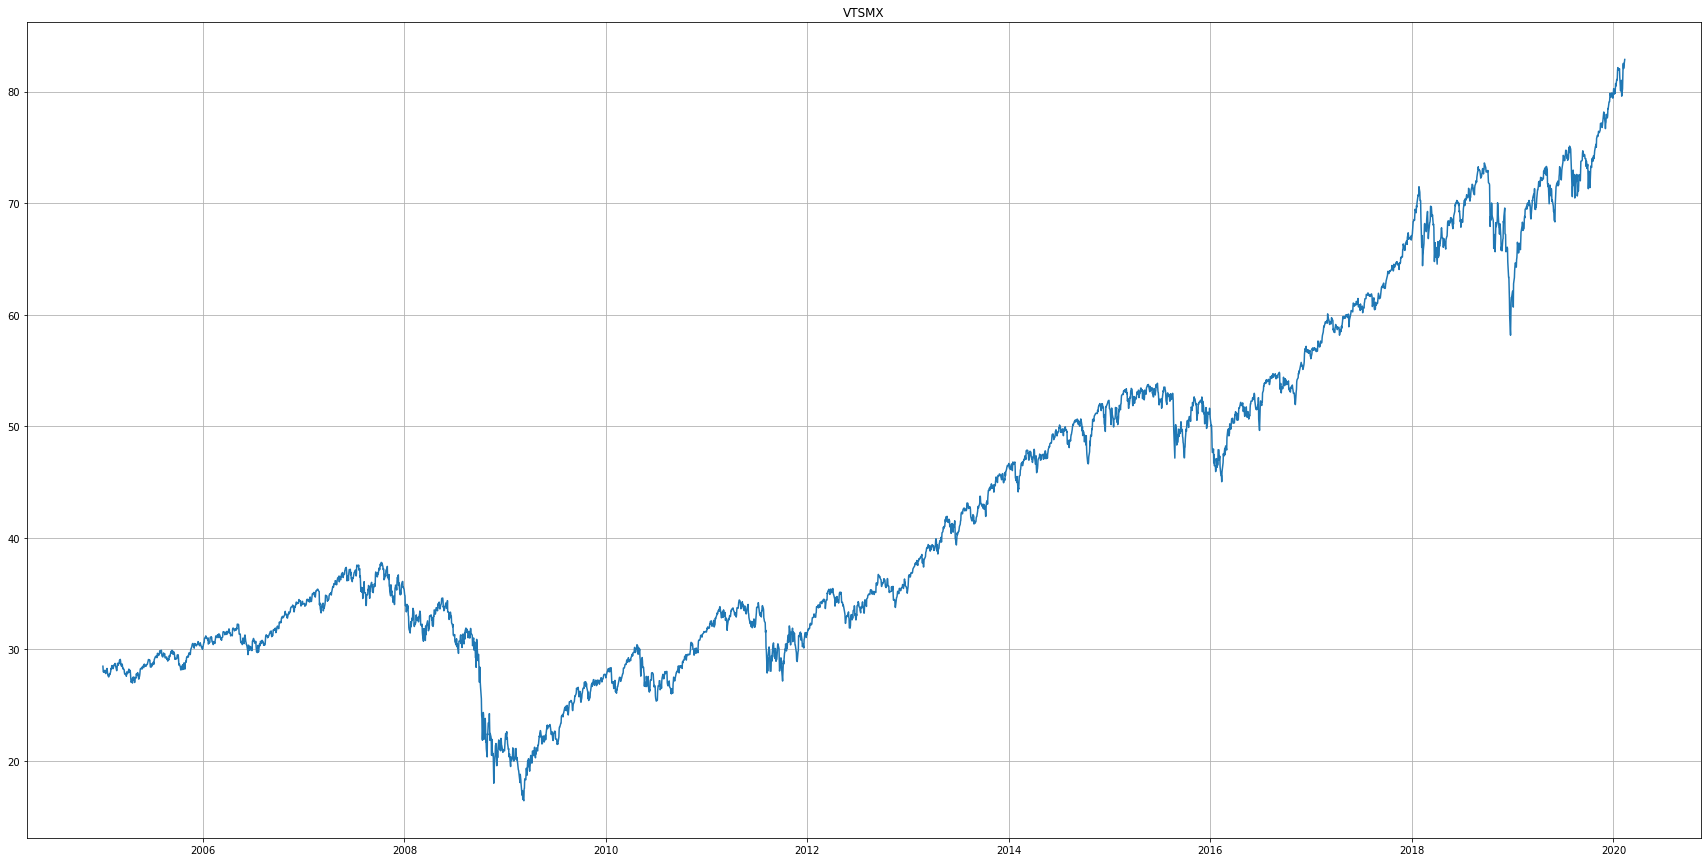

In [15]:
plt.rcParams['figure.figsize'] = [30, 15]
p = plt.plot(df["timestamp"], df["vtsmx_close"])

plt.title("VTSMX")
plt.grid()

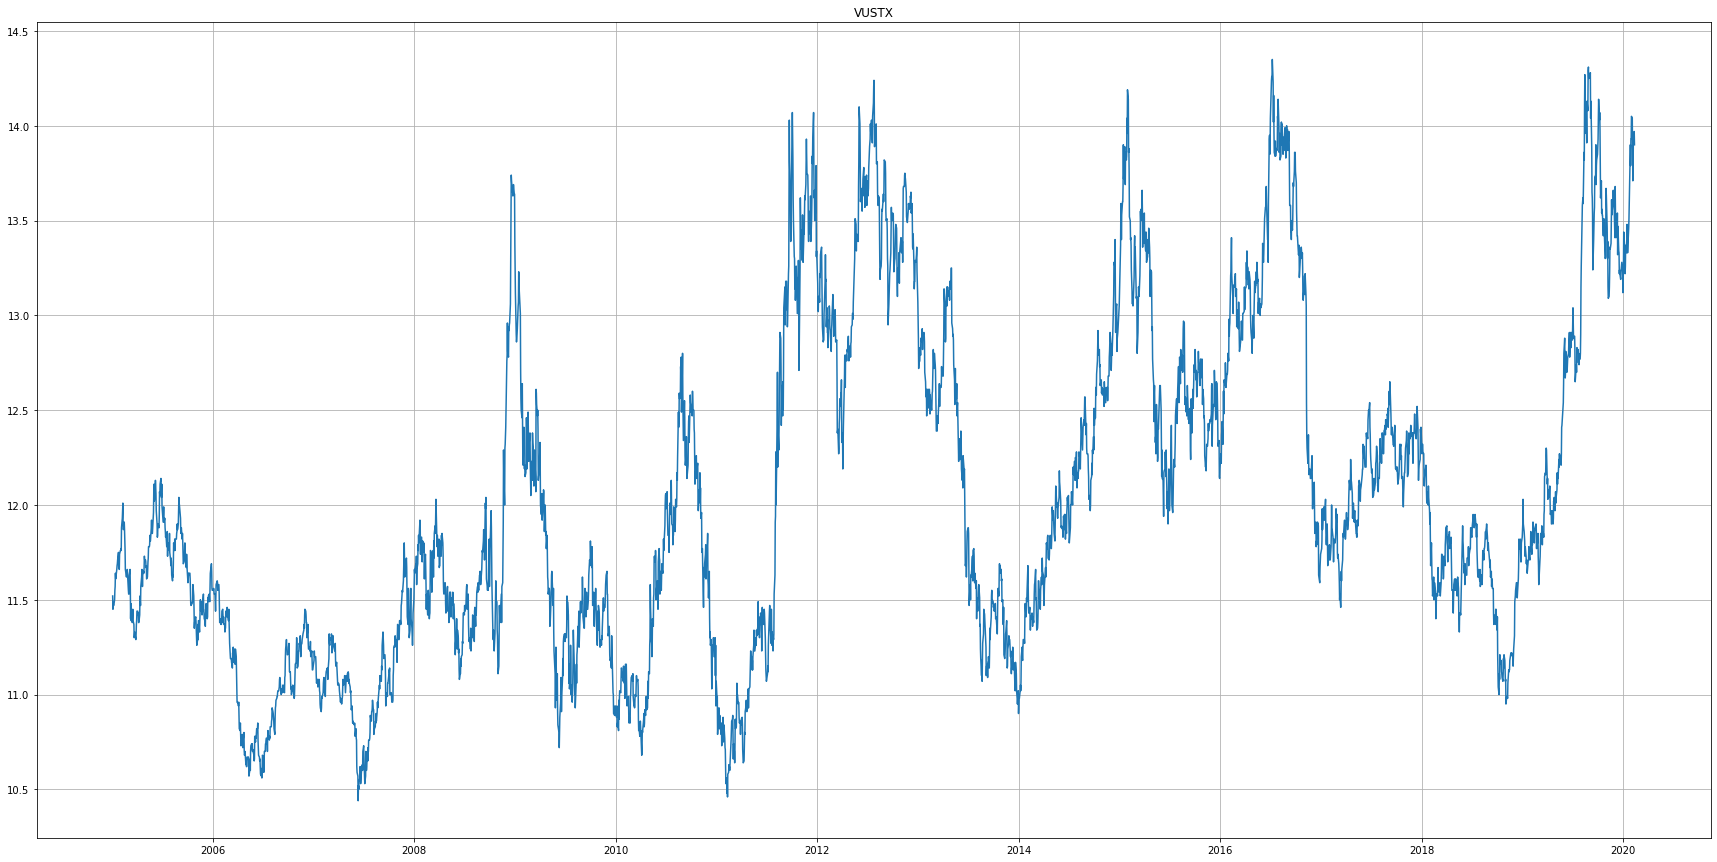

In [16]:
plt.rcParams['figure.figsize'] = [30, 15]
p = plt.plot(df["timestamp"], df["vustx_close"])

plt.title("VUSTX")
plt.grid()

In [17]:
df["vustx_close_last_day"] = df["vustx_close"].shift(periods=1, fill_value=0)

In [18]:
df["vtsmx_close_last_day"] = df["vtsmx_close"].shift(periods=1, fill_value=0)

In [19]:
df["vix_close_last_day"] = df["vix_close"].shift(periods=1, fill_value=0)

In [20]:
df["vustx_close_diff"] = df["vustx_close"] - df["vustx_close_last_day"]
df["vtsmx_close_diff"] = df["vtsmx_close"] - df["vtsmx_close_last_day"]
df["vix_close_diff"] = df["vix_close"] - df["vix_close_last_day"]

In [21]:
df["vustx_close_diff_rate"] = df["vustx_close_diff"] / df["vustx_close_last_day"]
df["vtsmx_close_diff_rate"] = df["vtsmx_close_diff"] / df["vtsmx_close_last_day"]
df["vix_close_diff_rate"] = df["vix_close_diff"] / df["vix_close_last_day"]

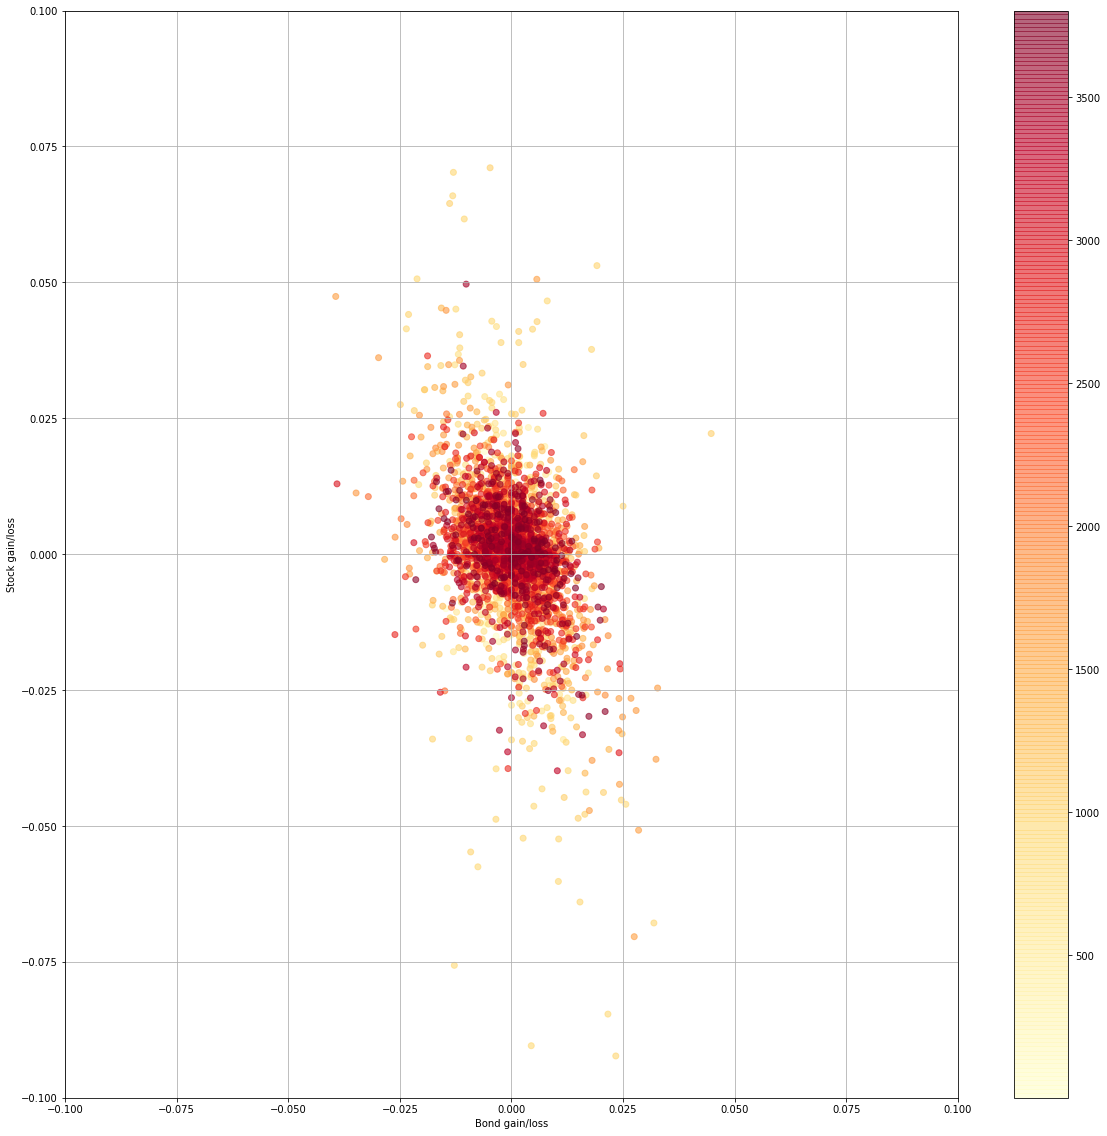

In [22]:
color_by_date = True

plt.rcParams['figure.figsize'] = [20, 20]

fig = plt.figure()

sub_plt = fig.add_subplot(1, 1, 1)

scatter = sub_plt.scatter(
    df["vustx_close_diff_rate"],
    df["vtsmx_close_diff_rate"],
    c=range(df["vustx_close_diff_rate"].count()) if color_by_date else None,
    alpha=0.6,
    cmap='YlOrRd')

sub_plt.grid()

plt.ylim((-0.1, 0.1))
plt.xlim((-0.1, 0.1))

plt.xlabel("Bond gain/loss")
plt.ylabel("Stock gain/loss")

fig.colorbar(scatter) if color_by_date else None

In [23]:
window = 240

both_drop = np.nan_to_num(
    (
        (df["vustx_close_diff_rate"] < 0) & (df["vtsmx_close_diff_rate"] < 0)
    ).rolling(window).sum().to_numpy()
)

both_rise = np.nan_to_num(
    (
        (df["vustx_close_diff_rate"] > 0) & (df["vtsmx_close_diff_rate"] > 0)
    ).rolling(window).sum().to_numpy()
)

bond_drop_sp_rise = np.nan_to_num(
    (
        (df["vustx_close_diff_rate"] < 0) & (df["vtsmx_close_diff_rate"] > 0)
    ).rolling(window).sum().to_numpy()
)

bond_rise_sp_drop = np.nan_to_num(
    (
        (df["vustx_close_diff_rate"] > 0) & (df["vtsmx_close_diff_rate"] < 0)
    ).rolling(window).sum().to_numpy()
)

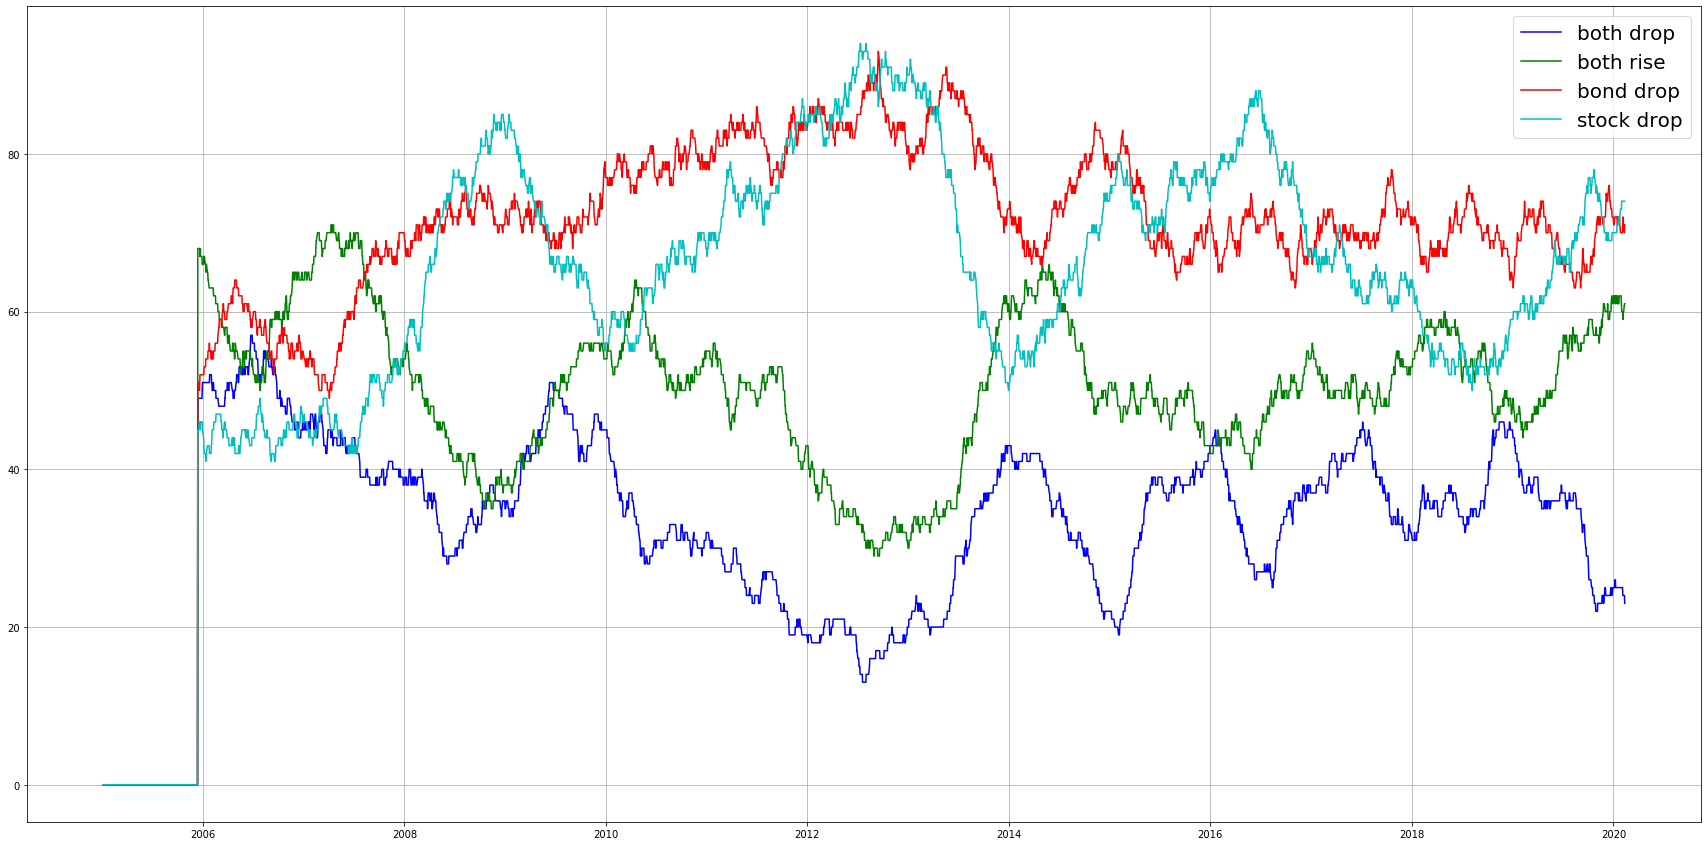

In [24]:
plt.rcParams['figure.figsize'] = [30, 15]

p1 = plt.plot(df["timestamp"], both_drop, "b", label="both drop")
p2 = plt.plot(df["timestamp"], both_rise, "g", label="both rise")
p3 = plt.plot(df["timestamp"], bond_drop_sp_rise, "r", label="bond drop")
p4 = plt.plot(df["timestamp"], bond_rise_sp_drop, "c", label="stock drop")

plt.legend(prop={'size': 20})
plt.grid()

In [25]:
def smooth(data):
    xnew = np.linspace(data.min(), data.max(), 300) 

    spl = make_interp_spline(spl, data, k=3)  # type: BSpline
    power_smooth = spl(xnew)

    return power_smooth


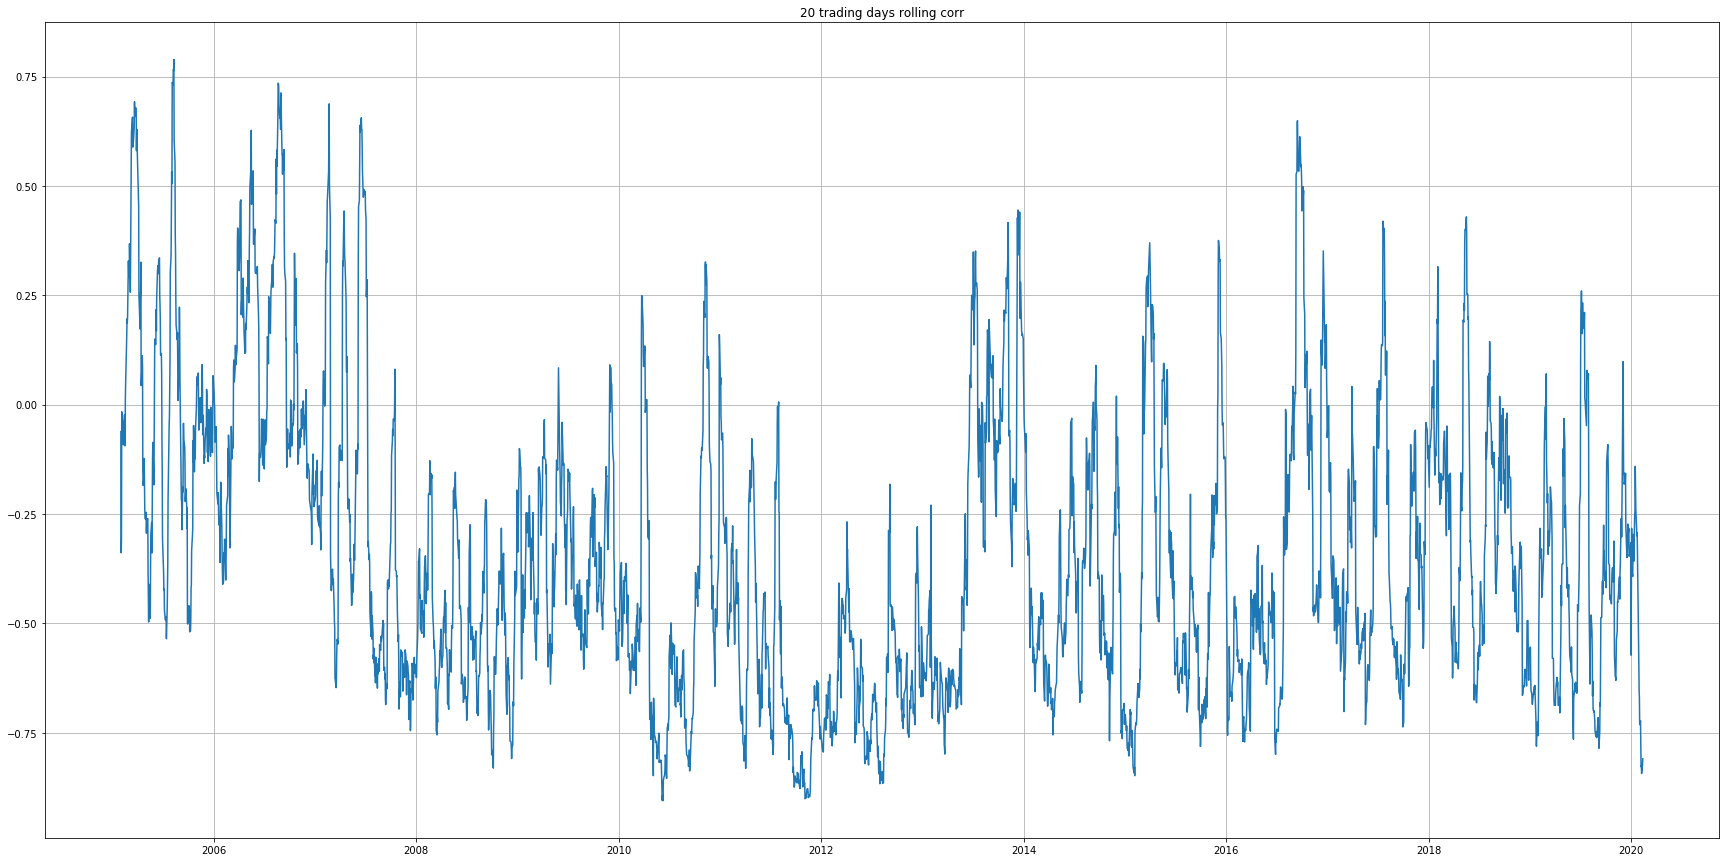

In [26]:
plt.rcParams['figure.figsize'] = [30, 15]

window_days = 20

df['corr'] = df["vustx_close_diff"].rolling(window_days).corr(df["vtsmx_close_diff_rate"])
plt.plot(df["timestamp"], df['corr'])
plt.title("{} trading days rolling corr".format(window_days))
plt.grid()